# MNIST Dataset: Density Forests
Trains a simple CNN on _N-1_ classes of the MNIST dataset, predicts unseen classes using baseline methods and Density Forest.

In [1]:
# choose GPUs
import os, sys
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # sys.argv[2]

In [2]:
#import libraries
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn import decomposition, svm
from tensorflow.python.client import device_lib
import pandas as pd

#custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from density_forest.density_forest import *
from density_forest.helpers import *
from baselines.helpers import *
from helpers.helpers import *
from helpers.plots import *
from helpers.parameter_search import *

# print available devices
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3163409138080198365
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10921197568
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 17967384100789966429
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [1]:
df_ps = pd.read_csv('mnist_models/hyperparams.csv', index_col=0)
df_ps

NameError: name 'pd' is not defined

In [3]:
label_to_remove = 7  # int(sys.argv[1])
paramsearch=True

# the data, shuffled and split between train and test sets
def load_data(label_to_remove):
    (x_train_all, y_train_all), (x_test_all, y_test_all) = mnist.load_data()
    print(np.unique(y_train_all, return_counts=True))

    # remove all trainig samples containing a label label_to_remove
    x_train = x_train_all[y_train_all != label_to_remove]
    y_train = y_train_all[y_train_all != label_to_remove]

    x_test = x_test_all[y_test_all != label_to_remove]
    y_test = y_test_all[y_test_all != label_to_remove]

    # decrease all labels that are higher by -1 to avoid gaps
    for i in range(label_to_remove + 1, 11):
        y_train[y_train == i] = (i-1)
        y_test[y_test == i] = (i-1)
    print(np.unique(y_train, return_counts=True))    
    
    batch_size = 128
    num_classes = 9
    epochs = 5

    # input image dimensions
    img_rows, img_cols = 28, 28

    # Reshape for Tensorflow
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_test_all = x_test_all.astype('float32')
    x_train /= 255
    x_test /= 255
    x_test_all /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.np_utils.to_categorical(y_test, num_classes)


    return x_train_all, y_train_all, x_test_all, y_test_all, x_train, y_train, x_test, y_test, batch_size, num_classes, epochs, img_rows, img_cols, input_shape

x_train_all, y_train_all, x_test_all, y_test_all, x_train, y_train, x_test, y_test, batch_size, num_classes, epochs, img_ros, img_cols, input_shape = load_data(label_to_remove)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))
x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False
if model_train:
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              verbose=1, validation_data=(x_test, y_test))
    model.save('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')
else:
    model = load_model('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [5]:
def OA(y_true, y_pred):
        """get overall accuracy"""
        return np.sum(y_true == y_pred)/len(y_true)

def AA(y_true, y_pred):
    """get average (macro) accuracy"""
    acc_cl = []
    for label in np.unique(y_true):
        acc_cl.append(np.sum(y_true[y_pred==label] == y_pred[y_pred==label])/len(y_pred[y_pred==label]))
    return np.mean(acc_cl), acc_cl

In [6]:
# get all predictions in training and test set
oa_trs = []
aa_trs = []
oa_tes = []
aa_tes = []

# for label_to_remove in range(10):
"""
get mean oa, aa for tr and te for all labels
"""
print(label_to_remove)
x_train_all, y_train_all, x_test_all, y_test_all, x_train, y_train, x_test, y_test, batch_size, num_classes, epochs, img_ros, img_cols, input_shape = load_data(label_to_remove)
model = load_model('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')
y_pred_tr = model.predict(x_train_all[..., np.newaxis], verbose=True)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=label_to_remove, background=False)

y_pred_te = model.predict(x_test_all, verbose=True)
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=label_to_remove, background=False)

# get indices of correctly / incorrectly predicted images
pred_t_tr = y_train_all != label_to_remove
pred_f_tr = y_train_all == label_to_remove

pred_t_te = y_test_all != label_to_remove
pred_f_te = y_test_all == label_to_remove

# get overall and average accuracy for training and test set


oa_tr = OA(y_train_all[y_train_all!=label_to_remove], y_pred_label_tr[y_train_all!=label_to_remove])
aa_tr, aa_tr_cl = AA(y_train_all[y_train_all!=label_to_remove], y_pred_label_tr[y_train_all!=label_to_remove])

oa_te = OA(y_test_all[y_test_all!=label_to_remove], y_pred_label_te[y_test_all!=label_to_remove])
aa_te, aa_te_cl = AA(y_test_all[y_test_all!=label_to_remove], y_pred_label_te[y_test_all!=label_to_remove])
oa_trs.append(oa_tr)
aa_trs.append(aa_tr)

oa_tes.append(oa_te)
aa_tes.append(aa_te)

print("OA training set: %.2f" % (oa_tr*100))
print("AA training set: %.2f" % (aa_tr*100))

print("OA test set: %.2f" % (oa_te*100))
print("AA test set: %.2f" % (aa_te*100))

7
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))
x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples
10000/10000 [==============================] - 1s 55us/step
OA training set: 99.39
AA training set: 99.38
OA test set: 99.20
AA test set: 99.19


In [7]:
print(np.round(np.multiply(oa_trs,100),2))
print(np.round(np.multiply(aa_trs,100),2))
print(np.round(np.multiply(oa_tes,100),2))
print(np.round(np.multiply(aa_tes,100),2))

[99.39]
[99.38]
[99.2]
[99.19]


#### Make some predictions for the unseen class

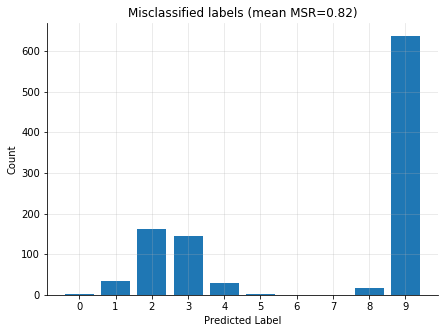

In [8]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all == label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = get_y_pred_labels(y_pred, label_to_remove, background=False)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label, return_counts=True)

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Misclassified labels (mean MSR=%.2f)" % np.mean(get_acc_net_msr(y_pred)))
plt.savefig("../Figures/MNIST/Pred_count/pred-count_wo_cl" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [9]:
# Avarage certitude for unseen class: 1-max_margin
c = get_acc_net_max_margin(y_pred)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean * 100))
print("Std accuracy: %.2f %%" % (pred_acc_std * 100))

pred_acc_high = .95

pct = np.round(len(c[c > pred_acc_high]) / len(c), 4) * 100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 68.64 %
Std accuracy: 31.61 %
30.45% of all predictions made with an accuracy higher than 0.95%


In [10]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = get_y_pred_labels(y_pred_seen, label_to_remove, background=False)

c = get_acc_net_max_margin(y_pred_seen)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean * 100))
print("Std accuracy: %.2f %%" % (pred_acc_std * 100))

pred_acc_high = .95

pct = np.round(len(c[c > pred_acc_high])/len(c), 4) * 100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 98.74 %
Std accuracy: 7.92 %
96.43 % of all predictions made with an accuracy higher than 0.95%


## Network accuracy

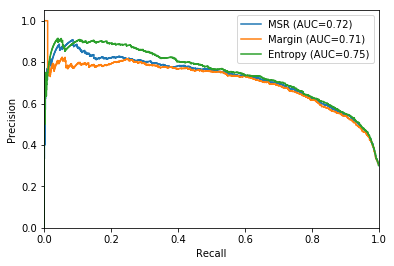

In [11]:
# precision-recall curves

# msr
y_scores = 1-get_acc_net_msr(y_pred_te)
y_true = pred_f_te
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = 1-get_acc_net_max_margin(y_pred_te)
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = 1-get_acc_net_entropy(y_pred_te)
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin, precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)' % pr_auc_msr),
            str.format('Margin (AUC=%.2f)' % pr_auc_margin),
            str.format('Entropy (AUC=%.2f)' % pr_auc_entropy)])

# Dropout

In [12]:
y_preds = predict_with_dropouts_batch(model, x_test_all, 
                                      batch_size=100, n_iter=5)

100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


In [13]:
y_pred = np.mean(y_preds, axis=0)
probas = -get_acc_net_entropy(y_pred)

In [14]:
# Metrics
# PR
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, probas)
pr_auc_dropout = metrics.auc(recall_dropout, precision_dropout)
# ROC
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, probas)
auroc_dropout = metrics.roc_auc_score(y_true, probas)

# Density Forest
## Get Activations, PCA, t-SNE

In [15]:
# get activation weights of last layer
act_unseen = get_activations_batch(model, 6, x_unseen_class, verbose=True)
act_train_all = get_activations_batch(model, 6, x_train_all[..., np.newaxis], verbose=True)
act_train = act_train_all[y_train_all != label_to_remove]
act_test = get_activations_batch(model, 6, x_test_all, verbose=True)

100%|██████████| 500/500 [00:00<00:00, 637.85it/s]


In [16]:
pts_per_class = 150
n_classes = 10
dataset_subset_indices = get_balanced_subset_indices(y_test_all, np.arange(n_classes), pts_per_class)

In [17]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization before PCA
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.010s...
[t-SNE] Computed neighbors for 1500 samples in 0.512s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 3.458543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.806725
[t-SNE] Error after 300 iterations: 0.901969


In [18]:
# color scale and legend for t-sne plots
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))[:, :3]
names = ['Class ' + str(i) for i in range(10)]
classes_to_keep = np.asarray([x for x in range(n_classes) if x != label_to_remove])

# plot
tsne_y = y_test_all[np.concatenate(dataset_subset_indices)]

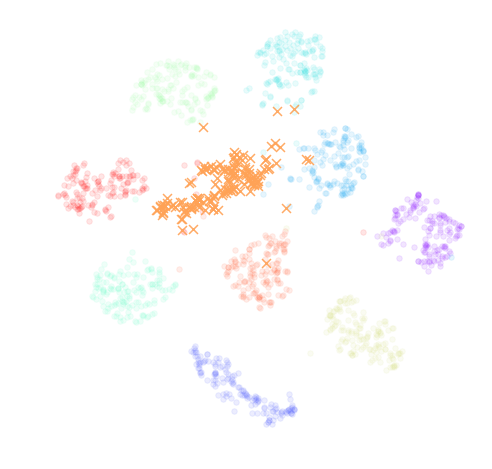

In [20]:
# plot
_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep,
            colors, class_to_remove=label_to_remove)
ax.set_axis_off()

plt.savefig("../Figures/MNIST/tSNE/MNIST_t-SNE_wo_cl_" + str(label_to_remove) + "_before.pdf", bbox_inches='tight', pad_inches=0)

In [21]:
pca = decomposition.PCA(n_components=.95)
pca.fit(act_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Variance explained by first 36 components: 0.95


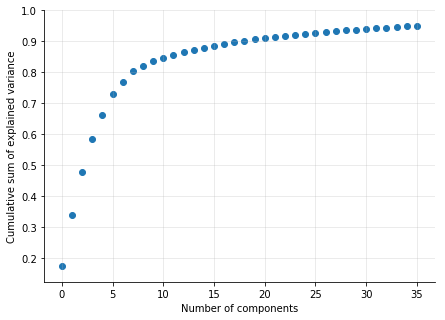

In [22]:
# PCA
pca = decomposition.PCA(n_components=.95)
pca.fit(act_train)


# plot
print("Variance explained by first %i components: %.2f" % (len(pca.components_), 
                                                           np.sum(pca.explained_variance_ratio_[:len(pca.components_)])))

fig = plt.figure(figsize=(7, 5))
plt.scatter(np.arange(len(pca.components_)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.savefig("../Figures/MNIST/PCA/MNIST_pca_components_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [23]:
# fit PCA
X_train_all = pca.transform(act_train_all)
X_train = pca.transform(act_train)
X_test = pca.transform(act_test)

#### Visualize PCA

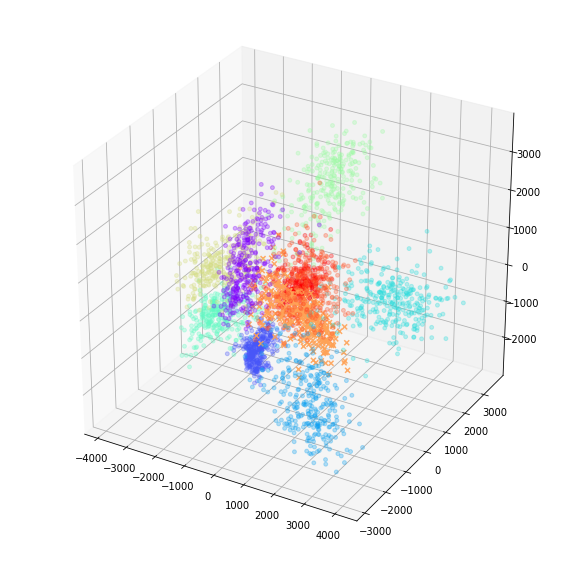

In [24]:
# test sample (with unseen class)
plot_pts_3d(X_train_all, y_train_all, classes_to_keep, colors, class_to_remove=label_to_remove, 
            subsample_pct=.05, s_name="../Figures/MNIST/PCA/MNIST_PCA_3D_wo_cl_" + str(label_to_remove) + ".pdf")

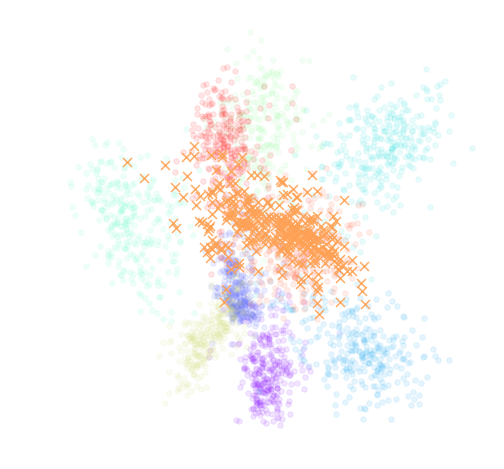

In [25]:
# test sample (with unseen class)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(X_train_all, y_train_all, ax, classes_to_keep, colors, class_to_remove=label_to_remove, 
            subsample_pct=.05)
ax.set_axis_off()
plt.savefig("../Figures/MNIST/PCA/MNIST_PCA_2D_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [26]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 1.908s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.928692
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.375061
[t-SNE] Error after 300 iterations: 2.717324


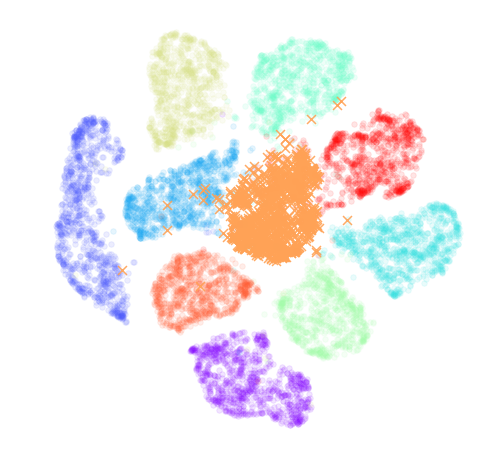

In [27]:
# plot
_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(tsne_all, y_test_all, ax, classes_to_keep,
            colors, class_to_remove=label_to_remove)
ax.set_axis_off()

plt.savefig("../Figures/MNIST/tSNE/MNIST_t-SNE_wo_cl_" + str(label_to_remove) + "_after.pdf", bbox_inches='tight', pad_inches=0)

In [28]:
tsne_train = tsne_all[y_test_all != label_to_remove]

### GMM
GMM, calculate 

In [78]:
# parameter search
if paramsearch:
    tuned_parameters = [{'n_components': np.arange(3, 10), 'max_iter': [10000]}]
    # do parameter search
    ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, X_train, X_train_all,
                             pred_f_tr.flatten(), scorer_roc_probas_gmm, 
                             n_iter=3, verbosity=10, n_jobs=-1, subsample_train=.01, subsample_test=.01)
    ps_gmm.fit()
    best_params_gmm = ps_gmm.best_params

else:
    best_params_gmm = {'n_components': df_ps.loc[str(names[label_to_remove])]['gmm_n_components'], 'max_iter': 10000}

print(best_params_gmm)

Trying parameters: {'max_iter': 10000, 'n_components': 3}
Trying parameters: {'max_iter': 10000, 'n_components': 4}
Trying parameters: {'max_iter': 10000, 'n_components': 5}
Trying parameters: {'max_iter': 10000, 'n_components': 6}
Trying parameters: {'max_iter': 10000, 'n_components': 7}
Trying parameters: {'max_iter': 10000, 'n_components': 8}


[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=40)]: Done   2 out of   7 | elapsed:    0.5s remaining:    1.1s


Trying parameters: {'max_iter': 10000, 'n_components': 9}


[Parallel(n_jobs=40)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=40)]: Done   4 out of   7 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=40)]: Done   5 out of   7 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=40)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   7 out of   7 | elapsed:    0.9s finished


{'max_iter': 10000, 'n_components': 9}


In [31]:
# fit model
gmm = GaussianMixture(**best_params_gmm)
gmm.fit(X_test)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
        means_init=None, n_components=9, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [32]:
# predict
probas = gmm.score_samples(X_test)

In [33]:
# Metrics
# PR
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, -probas)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, -probas)
auroc_gmm = metrics.roc_auc_score(y_true, -probas)

print("PR AUC: %.2f, AUROC: %.2f" % (pr_auc_gmm, auroc_gmm))

PR AUC: 0.11, AUROC: 0.57


## One-Class SVM

In [34]:
X_train_svm = preprocessing.scale(X_train)
X_train_all_svm = preprocessing.scale(X_train_all)
X_test_svm = preprocessing.scale(X_test)

/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [38]:
# parameter search
if paramsearch:
    tuned_parameters = [{'kernel': ['rbf'],
                         'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                         'degree':[1]
                         },
                        {'kernel': ['poly'],
                         'degree': np.arange(1, 4),
                         'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                         'max_iter': [10000]}]

    # do parameter search
    ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, X_train_svm, X_train_all_svm,
                             pred_f_tr.flatten(), scorer_roc_probas_svm, n_iter=5,
                             verbosity=11, n_jobs=-1, subsample_train=.001, subsample_test=.01)
    ps_svm.fit()
    best_params_svm = ps_svm.best_params
else:
    best_params_svm = {'kernel': df_ps.loc[str(names[label_to_remove])]['oc-svm_k'], 
                       'degree': df_ps.loc[str(names[label_to_remove])]['oc-svm_deg'], 
                       'nu': df_ps.loc[str(names[label_to_remove])]['oc_svm_nu'],
                       'max_iter': 100}
    
print(best_params_svm)

Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.0001}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.001}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.01}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.1}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.5}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=40)]: Done   3 out of  20 | elapsed:    0.4s remaining:    2.1s
[Parallel(n_jobs=40)]: Done   5 out of  20 | elapsed:    0.4s remaining:    1.3s


Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


[Parallel(n_jobs=40)]: Done   7 out of  20 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=40)]: Done   9 out of  20 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=40)]: Done  11 out of  20 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=40)]: Done  13 out of  20 | elapsed:    0.7s remaining:    0.4s


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  15 out of  20 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=40)]: Done  17 out of  20 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:    0.9s finished


{'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


In [39]:
clf_svm = svm.OneClassSVM(**best_params_svm, verbose=True)

In [40]:
clf_svm.fit(X_train_svm)

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='poly',
      max_iter=10000, nu=0.001, random_state=None, shrinking=True,
      tol=0.001, verbose=True)

In [41]:
probas = clf_svm.decision_function(X_test_svm)[:, 0]
probas -= np.min(probas)
probas /= np.max(probas)

In [42]:
# Metrics
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, -probas)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)
# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, -probas)
auroc_svm = metrics.roc_auc_score(y_true, -probas)

print("PR AUC: %.2f, AUROC: %.2f" % (pr_auc_svm, auroc_svm))

PR AUC: 0.27, AUROC: 0.77


# Density Forest

In [54]:
# parameter search
default_params = {'n_trees': 5, 'n_max_dim': 0, 'n_jobs': -1, 
                  'verbose': 0, 'subsample_pct': .02, 'min_subset': 0}

if paramsearch:
    """search for best hyperparameters"""
    tuned_params = [{'max_depth': [1, 2, 3, 4],
                     'ig_improvement': [0, .4, .7, .9]
                    }]

    # do parameter search
    ps_df = ParameterSearch(DensityForest, tuned_params, X_train, X_train_all,
                            pred_f_tr.flatten(), scorer_roc_probas_df,
                            n_iter=3, verbosity=11, n_jobs=1, subsample_train=1, 
                            subsample_test=.1, default_params=default_params)

    print("Testing %i combinations %i times" % (len(ps_df.combinations), ps_df.n_iter))
    print(ps_df.combinations)
    ps_df.fit()
    print(ps_df.best_params)
    
    # Create DensityForest instance
    best_params_df = ps_df.best_params
    
else:
    """use previously found hyperparameters"""
    best_params_df = {'max_depth': df_ps.loc[str(names[label_to_remove])]['df_depth'],
                      'ig_improvement': df_ps.loc[str(names[label_to_remove])]['df_min_ig']}
    
    
print(best_params_df)
default_params['verbose'] = 1
default_params['batch_size'] = 100
default_params['n_trees'] = 20

Testing 16 combinations 3 times
[{'ig_improvement': 0, 'max_depth': 1}
 {'ig_improvement': 0, 'max_depth': 2}
 {'ig_improvement': 0, 'max_depth': 3}
 {'ig_improvement': 0, 'max_depth': 4}
 {'ig_improvement': 0.4, 'max_depth': 1}
 {'ig_improvement': 0.4, 'max_depth': 2}
 {'ig_improvement': 0.4, 'max_depth': 3}
 {'ig_improvement': 0.4, 'max_depth': 4}
 {'ig_improvement': 0.7, 'max_depth': 1}
 {'ig_improvement': 0.7, 'max_depth': 2}
 {'ig_improvement': 0.7, 'max_depth': 3}
 {'ig_improvement': 0.7, 'max_depth': 4}
 {'ig_improvement': 0.9, 'max_depth': 1}
 {'ig_improvement': 0.9, 'max_depth': 2}
 {'ig_improvement': 0.9, 'max_depth': 3}
 {'ig_improvement': 0.9, 'max_depth': 4}]
Trying parameters: {'ig_improvement': 0, 'max_depth': 1, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0, 'max_depth': 2, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 3, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0, 'max_depth': 4, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.7min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 1, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.1min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 2, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.5min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 3, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 4, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 10.5min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 1, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.0min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 2, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 13.7min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 3, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 15.1min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 4, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.9, 'max_depth': 1, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.9, 'max_depth': 2, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.9, 'max_depth': 3, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.9, 'max_depth': 4, 'min_subset': 0, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 5, 'subsample_pct': 0.02, 'verbose': 0}
{'ig_improvement': 0.7, 'max_depth': 4}
{'ig_improvement': 0.7, 'max_depth': 4}


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 25.0min finished


In [65]:
# Create DensityForest instance
clf_df = DensityForest(**best_params_df, **default_params)
clf_df.fit(X_train)

Number of points on which to train each tree: 1074
Minimum number of points in each leaf: 0


[Parallel(n_jobs=40)]: Done   4 out of  20 | elapsed:  1.7min remaining:  6.7min
[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:  1.8min finished


Number of created root nodes: 19
Mean number of clusters created per tree: 2


In [67]:
probas = clf_df.predict(X_test)

Total steps: 100
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done  20 out of  99 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=40)]: Done  99 out of  99 | elapsed:    0.9s finished


In [68]:
covs, means = get_clusters(clf_df.root_nodes[1], [], [])

0.42267281911134497

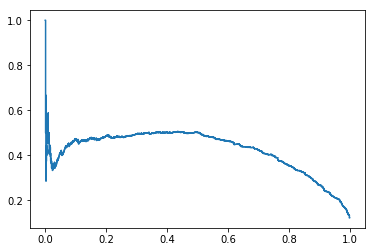

In [69]:
# precision-recall curve
y_scores = -probas
# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)
# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_df, precision_df)
metrics.auc(recall_df, precision_df)

## Plot Results

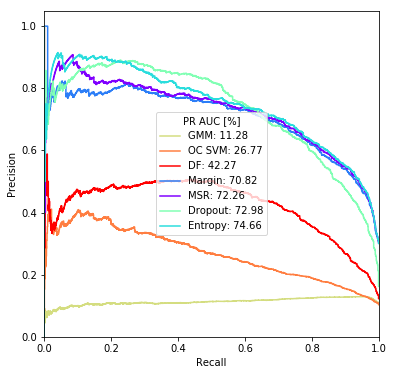

In [70]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = np.multiply([pr_auc_msr, pr_auc_margin, pr_auc_entropy, 
                         pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df], 100)

recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, 
              precision_dropout, precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC [%]")
plt.savefig("../Figures/MNIST/Metrics/PR_ED_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

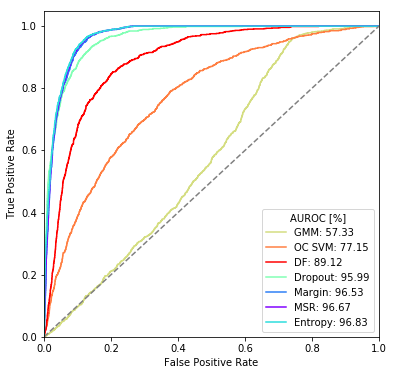

In [71]:
# ROC
# order according to increasing score
scores_auc = np.multiply([auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df], 100)
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC [%]")
plt.savefig("../Figures/MNIST/Metrics/ROC_ED_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [79]:
# write best hyperparameters to CSV file
best_params = {'gmm_n_components': best_params_gmm['n_components'], 
               'oc-svm_k': best_params_svm['kernel'], 
               'oc-svm_deg': best_params_svm['degree'], 
               'oc_svm_nu': best_params_svm['nu'], 
               'df_depth': best_params_df['max_depth'], 
               'df_min_ig': best_params_df['ig_improvement']}

In [89]:
# write results to CSV files
# hyperparameters
df2 = pd.DataFrame(best_params, index=[str(names[label_to_remove])])
df_ps = df_ps.append(df2)
df_ps = df_ps[~df_ps.index.duplicated(keep='last')]  # avoid duplicates
df_ps.to_csv('mnist_models/hyperparams.csv')

# AUROC
df_auroc = pd.read_csv('mnist_models/auroc_all.csv', index_col=0)
df2 = pd.DataFrame({str(names[label_to_remove]): scores_auc}, index=names_methods).T
df_auroc = df_auroc.append(df2)
df_auroc = df_auroc[~df_auroc.index.duplicated(keep='last')]  # avoid duplicates
df_auroc.to_csv('mnist_models/auroc_all.csv')


# PR AUC
df_aucpr = pd.read_csv('mnist_models/aucpr_all.csv', index_col=0)
df2 = pd.DataFrame({str(names[label_to_remove]): scores_pr}, index=names_methods).T
df_aucpr = df_aucpr.append(df2)
df_aucpr = df_aucpr[~df_aucpr.index.duplicated(keep='last')]  # avoid duplicates
df_aucpr.to_csv('mnist_models/aucpr_all.csv')